In [9]:
from skimage import io, color
from skimage.morphology import binary_closing, binary_opening
from skimage.morphology import disk
import matplotlib.pyplot as plt
import numpy as np
from skimage import measure
from skimage.color import label2rgb
import pydicom as dicom
from scipy.stats import norm
from scipy.spatial import distance


def show_comparison(original, modified, modified_name):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap="gray", vmin=-200, vmax=500)
    ax1.set_title('Original')
    ax1.axis('off')
    ax2.imshow(modified)
    ax2.set_title(modified_name)
    ax2.axis('off')
    io.show()

In [10]:
in_dir = "data/"
ct = dicom.read_file(in_dir + 'Training.dcm')
img = ct.pixel_array
print(img.shape)
print(img.dtype)

(512, 512)
int16


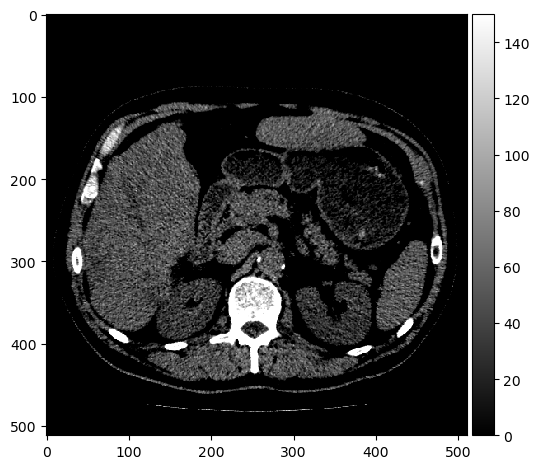

In [11]:
io.imshow(img, vmin=0, vmax=150, cmap='gray')
io.show()

In [12]:
spleen_roi = io.imread(in_dir + 'SpleenROI.png')
# convert to boolean image
spleen_mask = spleen_roi > 0
spleen_values = img[spleen_mask]

In [13]:
mu_spleen = np.mean(spleen_values)
std_spleen = np.std(spleen_values)

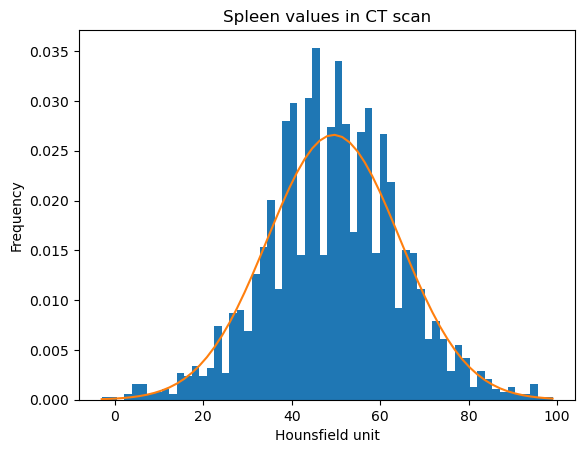

In [14]:
n, bins, patches = plt.hist(spleen_values, 60, density=1)
pdf_spleen = norm.pdf(bins, mu_spleen, std_spleen)
plt.plot(bins, pdf_spleen)
plt.xlabel('Hounsfield unit')
plt.ylabel('Frequency')
plt.title('Spleen values in CT scan')
plt.show()

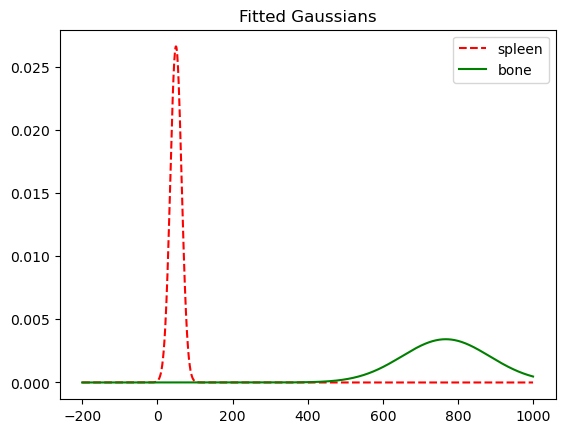

In [16]:
# Load the bone mask (BoneROI.png)
bone_roi = io.imread(in_dir + 'BoneROI.png')

# Convert the mask to a boolean array
bone_mask = bone_roi > 0

# Extract the bone values from the CT image using the mask
bone_values = img[bone_mask]

# Compute the mean (mu_bone) and standard deviation (std_bone)
mu_bone = np.mean(bone_values)
std_bone = np.std(bone_values)

min_hu = -200
max_hu = 1000
hu_range = np.arange(min_hu, max_hu, 1.0)
pdf_spleen = norm.pdf(hu_range, mu_spleen, std_spleen)
pdf_bone = norm.pdf(hu_range, mu_bone, std_bone)
plt.plot(hu_range, pdf_spleen, 'r--', label="spleen")
plt.plot(hu_range, pdf_bone, 'g', label="bone")
plt.title("Fitted Gaussians")
plt.legend()
plt.show()

In [31]:
in_dir = "data/"
ct = dicom.read_file(in_dir + 'Training.dcm')
img = ct.pixel_array

def compute_mu_std_for_organs(img, organs, in_dir):
    # Dictionary to store results for each organ
    organ_stats = {}

    for organ_name, mask_file in organs.items():

        organ_roi = io.imread(in_dir + mask_file)

        # Convert the mask to a boolean array
        organ_mask = organ_roi > 0

        # Extract the pixel values for the organ using the mask
        organ_values = img[organ_mask]

        # Compute the mean (mu) and standard deviation (std)
        mu = np.mean(organ_values)
        std = np.std(organ_values)

        # Store the results in the dictionary
        organ_stats[organ_name] = {'mean': mu, 'std': std, 'mask': organ_mask}

        # Print the results for this organ
        print(f"{organ_name} - Mean: {mu:.2f}, Std: {std:.2f}")

    return organ_stats

# Example usage
in_dir = "data/"

# Dictionary of organ names and corresponding mask file names
organs = {
    'spleen': 'SpleenROI.png',
    'bone': 'BoneROI.png',
    'liver': 'LiverROI.png',
    'kidneys': 'KidneyROI.png',
    'fat': 'FatROI.png',
    'background' : 'BackgroundROI.png'
}

# Call the function to compute mu and std for all organs
organ_stats = compute_mu_std_for_organs(img, organs, in_dir)


spleen - Mean: 49.48, Std: 15.00
bone - Mean: 766.94, Std: 116.56
liver - Mean: 45.41, Std: 15.35
kidneys - Mean: 29.61, Std: 15.32
fat - Mean: -103.39, Std: 11.32
background - Mean: -1011.17, Std: 18.96


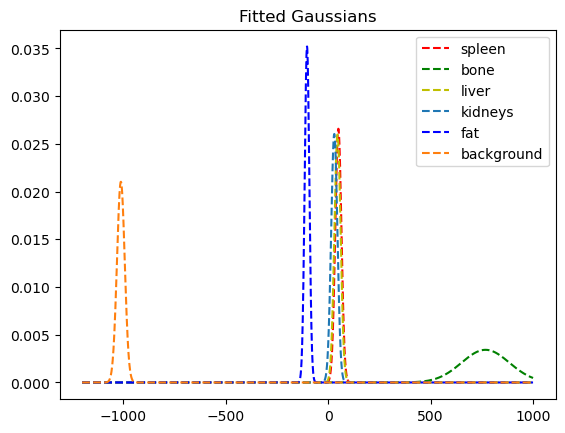

In [29]:
min_hu = -1200
max_hu = 1000
hu_range = np.arange(min_hu, max_hu, 1.0)
pdf_spleen = norm.pdf(hu_range, mu_spleen, std_spleen)
pdf_bone = norm.pdf(hu_range, mu_bone, std_bone)
pdf_liver= norm.pdf(hu_range, organ_stats['liver']['mean'], organ_stats['liver']['std'])
pdf_kidneys = norm.pdf(hu_range, organ_stats['kidneys']['mean'], organ_stats['kidneys']['std'])
pdf_fat = norm.pdf(hu_range, organ_stats['fat']['mean'], organ_stats['fat']['std'])
pdf_background = norm.pdf(hu_range, organ_stats['background']['mean'], organ_stats['background']['std'])
plt.plot(hu_range, pdf_spleen, 'r--', label="spleen")
plt.plot(hu_range, pdf_bone, 'g--', label="bone")
plt.plot(hu_range, pdf_liver, 'y--', label="liver")
plt.plot(hu_range, pdf_kidneys, '--', label="kidneys")
plt.plot(hu_range, pdf_fat, 'b--', label="fat")
plt.plot(hu_range, pdf_background, '--', label="background")
plt.title("Fitted Gaussians")
plt.legend()
plt.show()

In [32]:
import numpy as np
from skimage import io

# Threshold for background
t_background = -200

# Compute the average values (mu) for fat, soft tissue, and bone using masks
# Assuming you already have these from previous computations or functions

mu_fat = np.mean(img[organ_stats['fat']['mask']])   # mean value for fat tissue
mu_soft_tissue = np.mean(np.concatenate([img[spleen_mask], img[organ_stats['liver']['mask']], img[organ_stats['kidneys']['mask']]]))  # mean for soft tissue (spleen, liver, kidneys)
mu_bone = np.mean(img[bone_mask]) # mean value for bone

# Compute the thresholds as mid-points between the average values
t_fat_soft = (mu_fat + mu_soft_tissue) / 2  # threshold between fat and soft tissue
t_soft_bone = (mu_soft_tissue + mu_bone) / 2  # threshold between soft tissue and bone

# Apply thresholds to classify the pixels
background_img = img <= t_background
fat_img = (img > t_background) & (img <= t_fat_soft)
soft_tissue_img = (img > t_fat_soft) & (img <= t_soft_bone)
bone_img = img > t_soft_bone

# You can now use these binary images (background_img, fat_img, soft_tissue_img, bone_img) for further processing


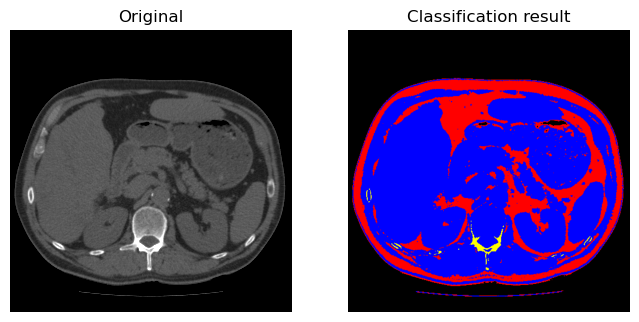

In [33]:
label_img = fat_img + 2 * soft_tissue_img + 3 * bone_img
image_label_overlay = label2rgb(label_img)
show_comparison(img, image_label_overlay, 'Classification result')
# We have red color for fat, blue for soft_tissue and white for bone

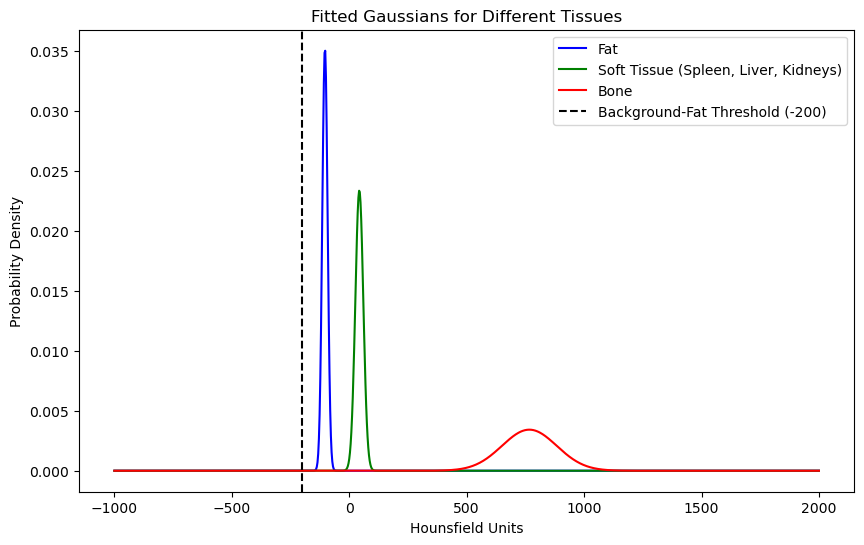

In [34]:
hu_range = np.linspace(-1000, 2000, 1000)
plt.figure(figsize=(10, 6))

std_soft_tissue = np.std(np.concatenate([img[spleen_mask], img[organ_stats['liver']['mask']], img[organ_stats['kidneys']['mask']]]))

# Fat tissue Gaussian
pdf_fat = norm.pdf(hu_range, mu_fat, organ_stats['fat']['std'])
plt.plot(hu_range, pdf_fat, label='Fat', color='blue')

# Soft tissue Gaussian
pdf_soft_tissue = norm.pdf(hu_range, mu_soft_tissue, std_soft_tissue)
plt.plot(hu_range, pdf_soft_tissue, label='Soft Tissue (Spleen, Liver, Kidneys)', color='green')

# Bone tissue Gaussian
pdf_bone = norm.pdf(hu_range, mu_bone, std_bone)
plt.plot(hu_range, pdf_bone, label='Bone', color='red')

# Background threshold (manually set)
plt.axvline(x=-200, color='black', linestyle='--', label='Background-Fat Threshold (-200)')

# Adding labels and legend
plt.title('Fitted Gaussians for Different Tissues')
plt.xlabel('Hounsfield Units')
plt.ylabel('Probability Density')
plt.legend()

plt.show()

In [46]:
test_value = 140

if norm.pdf(test_value, mu_soft_tissue, std_soft_tissue) > norm.pdf(test_value, mu_bone, std_bone):
	print(f"For value {test_value} the class is soft tissue")
else:
	print(f"For value {test_value} the class is bone")

For value 140 the class is soft tissue


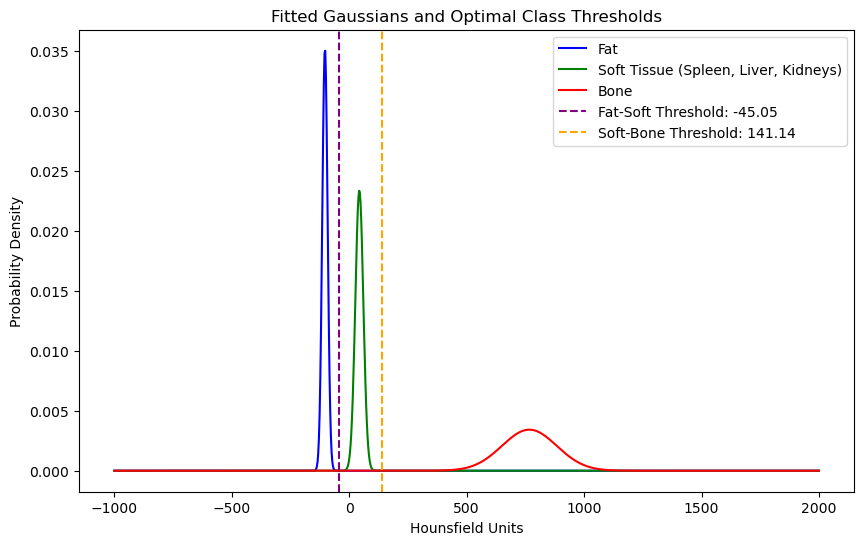

Optimal threshold between fat and soft tissue: -45.05
Optimal threshold between soft tissue and bone: 141.14


In [51]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Define the means and standard deviations for fat, soft tissue, and bone
mu_fat = organ_stats['fat']['mean']
std_fat = organ_stats['fat']['std']

mu_soft_tissue = np.mean(np.concatenate([img[spleen_mask], img[organ_stats['liver']['mask']], img[organ_stats['kidneys']['mask']]]))
std_soft_tissue = np.std(np.concatenate([img[spleen_mask], img[organ_stats['liver']['mask']], img[organ_stats['kidneys']['mask']]]))

mu_bone = np.mean(img[bone_mask])
std_bone = np.std(img[bone_mask])

# Define the Hounsfield unit range for calculations
hu_range = np.linspace(-1000, 2000, 1000)

# Get the PDF values for each class across the HU range
pdf_fat = norm.pdf(hu_range, mu_fat, std_fat)
pdf_soft_tissue = norm.pdf(hu_range, mu_soft_tissue, std_soft_tissue)
pdf_bone = norm.pdf(hu_range, mu_bone, std_bone)

# Restrict HU range between the two means for fat and soft tissue
fat_soft_range_mask = (hu_range >= mu_fat) & (hu_range <= mu_soft_tissue)

# Find the optimal threshold between fat and soft tissue, within the restricted range
idx_fat_soft = np.argmin(np.abs(pdf_fat[fat_soft_range_mask] - pdf_soft_tissue[fat_soft_range_mask]))
t_fat_soft = hu_range[fat_soft_range_mask][idx_fat_soft]

# Restrict HU range between the two means for soft tissue and bone
soft_bone_range_mask = (hu_range >= mu_soft_tissue) & (hu_range <= mu_bone)

# Find the optimal threshold between soft tissue and bone, within the restricted range
idx_soft_bone = np.argmin(np.abs(pdf_soft_tissue[soft_bone_range_mask] - pdf_bone[soft_bone_range_mask]))
t_soft_bone = hu_range[soft_bone_range_mask][idx_soft_bone]

# Plot the PDFs and mark the thresholds
plt.figure(figsize=(10, 6))

# Plot the Gaussians
plt.plot(hu_range, pdf_fat, label='Fat', color='blue')
plt.plot(hu_range, pdf_soft_tissue, label='Soft Tissue (Spleen, Liver, Kidneys)', color='green')
plt.plot(hu_range, pdf_bone, label='Bone', color='red')

# Plot the thresholds
plt.axvline(x=t_fat_soft, color='purple', linestyle='--', label=f'Fat-Soft Threshold: {t_fat_soft:.2f}')
plt.axvline(x=t_soft_bone, color='orange', linestyle='--', label=f'Soft-Bone Threshold: {t_soft_bone:.2f}')

# Labels and legend
plt.title('Fitted Gaussians and Optimal Class Thresholds')
plt.xlabel('Hounsfield Units')
plt.ylabel('Probability Density')
plt.legend()

plt.show()

# Print the optimal thresholds
print(f'Optimal threshold between fat and soft tissue: {t_fat_soft:.2f}')
print(f'Optimal threshold between soft tissue and bone: {t_soft_bone:.2f}')


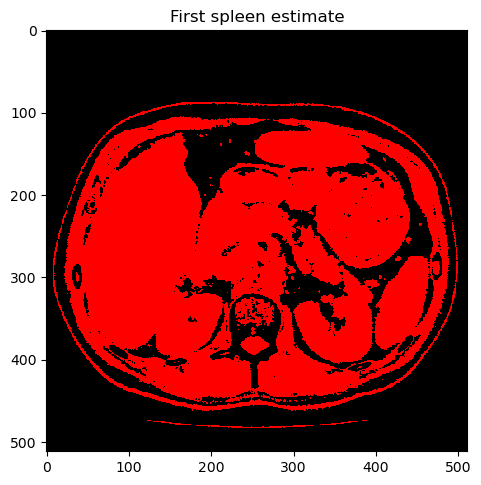

In [54]:
spleen_estimate = (img > -45.05) & (img < 141.14)
spleen_label_colour = color.label2rgb(spleen_estimate)
io.imshow(spleen_label_colour)
plt.title("First spleen estimate")
io.show()

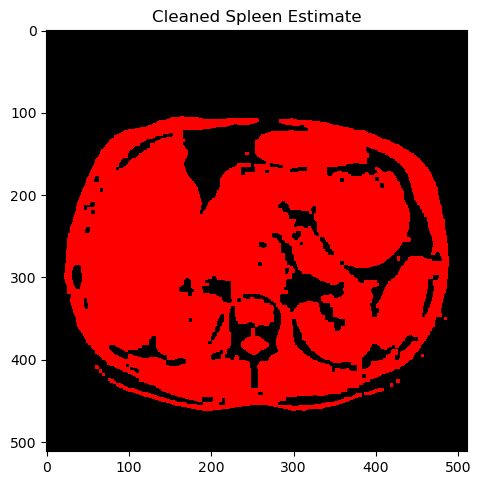

In [58]:
# Define the structural element (footprint)
footprint = disk(2.5)  # Adjust the size as necessary

# Apply binary closing to fill holes
closed = binary_closing(spleen_estimate, footprint)

# Apply binary opening to remove small objects
opened = binary_opening(closed, footprint)

# Visualize the result after morphological operations
spleen_label_colour_cleaned = color.label2rgb(opened)
io.imshow(spleen_label_colour_cleaned)
plt.title("Cleaned Spleen Estimate")
io.show()

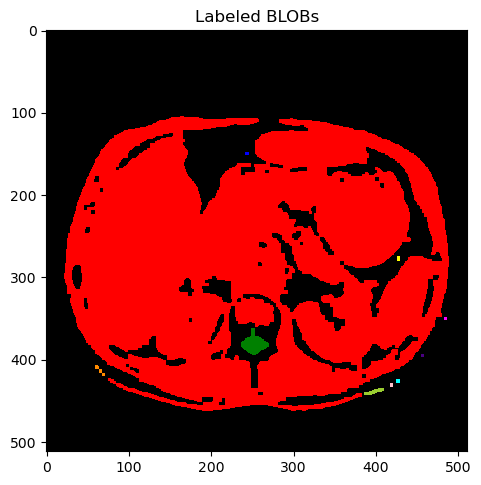

In [59]:

# Label the connected components (BLOBs)
label_img = measure.label(opened)

# Visualize the labeled BLOBs
io.imshow(color.label2rgb(label_img))
plt.title("Labeled BLOBs")
io.show()

The below does not really work

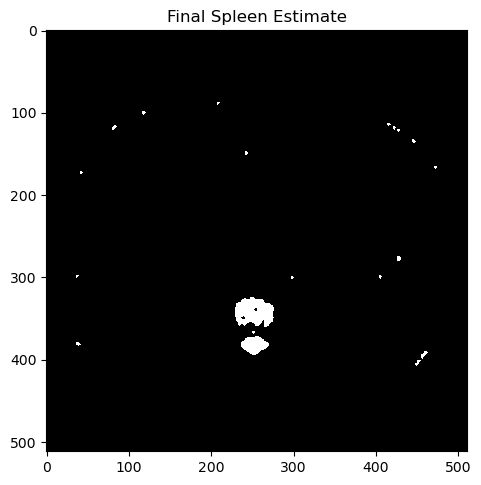

In [65]:
from skimage.measure import regionprops
from skimage.morphology import binary_closing, binary_opening, disk

def spleen_finder(img):
    # Thresholding for spleen
    t_1 = -45
    t_2 = 141
    spleen_estimate = (img > t_1) & (img < t_2)
    
    # Morphological operations
    footprint = disk(2.1)
    closed = binary_closing(spleen_estimate, footprint)
    opened = binary_opening(closed, footprint)
    
    # Label connected components (BLOBs)
    label_img = measure.label(opened)
    
    # Set area thresholds
    min_area = 0.1
    max_area = 20000
    
    # Filter based on area
    region_props = regionprops(label_img)
    label_img_filter = label_img.copy()
    for region in region_props:
        if region.area > max_area or region.area < min_area:
            for cords in region.coords:
                label_img_filter[cords[0], cords[1]] = 0
                
    # Return binary spleen image
    return label_img_filter > 0

# Test the function
spleen_img = spleen_finder(img)
io.imshow(spleen_img)
plt.title("Final Spleen Estimate")
io.show()


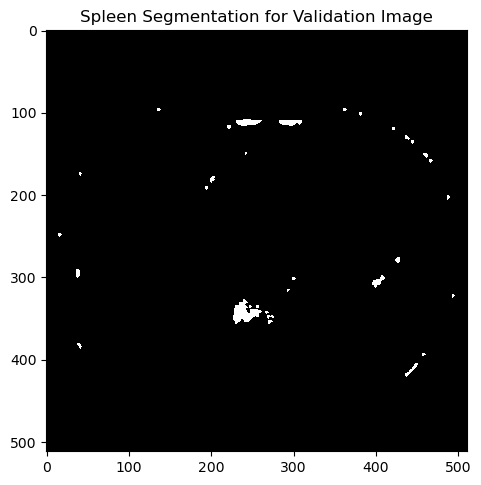

In [66]:


# Example: Load a validation image
validation_img = dicom.read_file(in_dir + 'Validation1.dcm').pixel_array

# Find the spleen
spleen_validation = spleen_finder(validation_img)

# Visualize the result
io.imshow(spleen_validation)
plt.title("Spleen Segmentation for Validation Image")
io.show()


In [71]:
#from scipy.spatial import distance

ground_truth_img = io.imread(in_dir + 'Validation1_spleen.png')
gt_bin = ground_truth_img > 0
dice_score = 1 - distance.dice(spleen_img.ravel(), gt_bin.ravel())
print(f"DICE score {dice_score}")

DICE score 0.0
